In [1]:
import os
import sys
import json
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from itertools import combinations
from scipy.stats import shapiro, f_oneway, kruskal
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from functions.plotting import plot_bars, plot_bar_from_dict

WIDTH = 150
HEIGHT = 150

In [2]:
data_dir = os.path.join(
    '..',
    '..',
    '..',
    'data1',
    'images_original_inception_resnet_v2_150x150_categorized')
test_data_dir = os.path.join(data_dir, 'validation')
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH),
    shuffle=False)

Found 2000 files belonging to 7 classes.


In [3]:
ROOT_NAME = 'inception'
models_dir = os.path.join(
    '..',
    '..',
    'models',
    'data1')
model_names = list(filter(lambda model_file_name: ROOT_NAME in model_file_name, os.listdir(models_dir)))

In [4]:
accuracies_data_path = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_accuracies.json')
losses_data_path = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_losses.json')

In [5]:
def get_accuracies_and_losses(models: list[str]) -> (dict[str, float], dict[str, float]):
    accuracies = {}
    losses = {}

    for model_name in models:
        model_path = os.path.join(models_dir, model_name)
        model = keras.models.load_model(model_path)
        eval_result = model.evaluate(test_ds)

        if len(eval_result) == 6:
            loss, categorical_cross_entropy, mse, accuracy, auc, prc = eval_result
        else:
            loss, accuracy = eval_result

        accuracies[model_name] = accuracy
        losses[model_name] = loss

    return accuracies, losses


if not os.path.exists(accuracies_data_path):
    accuracies, losses = get_accuracies_and_losses(model_names)

    with open(accuracies_data_path, 'w') as json_file:
        json.dump(accuracies, json_file, indent=4)
    with open(losses_data_path, 'w') as json_file:
        json.dump(losses, json_file, indent=4)

In [6]:
with open(accuracies_data_path, 'r') as accuracies_file:
    accuracies = json.load(accuracies_file)
with open(losses_data_path, 'r') as losses_file:
    losses = json.load(losses_file)

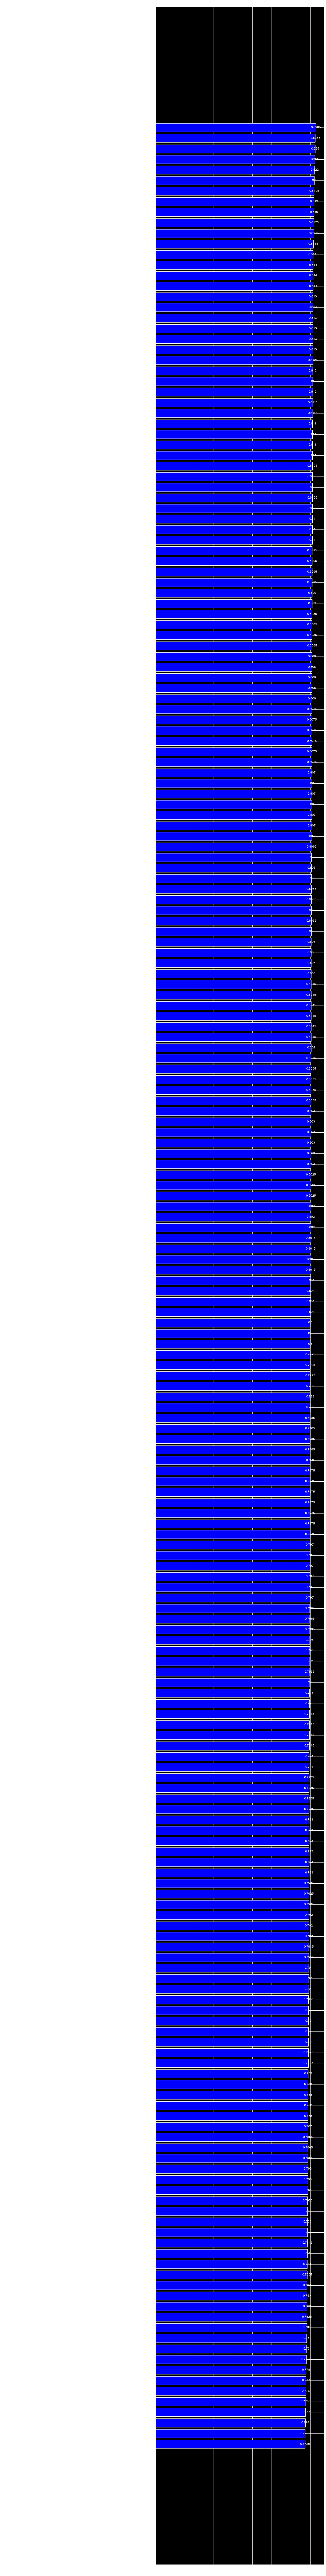

In [7]:
root = os.path.join('..', '..', 'plots', 'testing')
accuracies_path = os.path.join(root, f'{ROOT_NAME}_accuracies.pdf')

plot_bar_from_dict(accuracies, 'Model Accuracies', 'Name', 'Accuracy', accuracies_path)

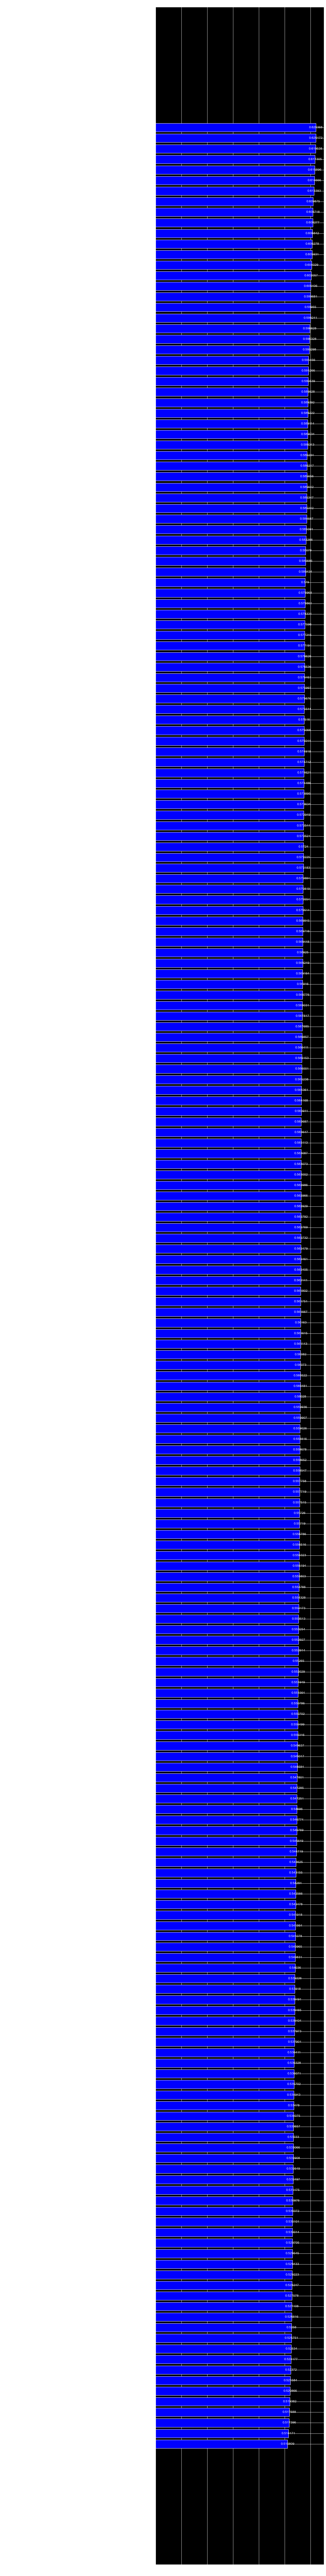

In [8]:
losses_path = os.path.join(root, f'{ROOT_NAME}_losses.pdf')

plot_bar_from_dict(losses, 'Model Losses', 'Name', 'Accuracy', losses_path)

Analysis part of model testing

In [9]:
model_categories = set(map(lambda name: '_'.join(name.split('_')[:-2]), model_names))
grouped_models = {key: list(filter(lambda name: name.startswith(key), model_names)) for key in model_categories}
keyed_accuracies = {key: [] for key in grouped_models}
keyed_losses = {key: [] for key in grouped_models}


def categorize_numbers(for_dict: dict[str, list[float]], numbers_dict: dict[str, float]) -> None:
    for group, value in for_dict.items():
        vals = [
            value for key, value in numbers_dict.items()
            if key.startswith(group)]

        value.extend(vals)


categorize_numbers(keyed_accuracies, accuracies)
categorize_numbers(keyed_losses, losses)

In [10]:
accuracies_df = pd.DataFrame(keyed_accuracies)
losses_df = pd.DataFrame(keyed_losses)

In [11]:
accuracies_df.describe()

,inception_10_class_weight_and_bias_whole_model_trainable_with_attention_module_on_top,inception_1_whole_model_trainable,inception_9_class_weight_and_bias_whole_model_trainable,inception_6_initial_bias_only_whole_model_trainable_and_attention_module_on_top,inception_8_class_weights_only_whole_model_trainable_and_attention_module_on_top,inception_5_initial_bias_only_whole_model_trainable,inception_11_samplewise_centering_whole_model_trainable,inception_4_only_bottom_half_layers_trainable_with_attention_module_on_top,inception_7_class_weights_only_whole_model_trainable,inception_2_only_bottom_half_layers_trainable,inception_3_whole_model_trainable_with_attention_module_on_top
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000
mean,0.801900,0.788650,0.805200,0.803325,0.801575,0.802200,0.804275,0.800050,0.803175,0.79065,0.798600
std,0.008314,0.010101,0.008506,0.009434,0.013119,0.009461,0.008304,0.008797,0.010532,0.00886,0.011348
min,0.786000,0.772500,0.787000,0.788000,0.783000,0.774000,0.781000,0.780000,0.778000,0.77450,0.777000
25%,0.796875,0.782875,0.801750,0.795875,0.791375,0.797500,0.801375,0.796000,0.794875,0.78475,0.792375
50%,0.801500,0.789500,0.806000,0.804000,0.800500,0.805750,0.803750,0.802500,0.805500,0.78900,0.798500
75%,0.805500,0.794625,0.810500,0.810000,0.809125,0.808625,0.809750,0.805875,0.808250,0.79675,0.804375
max,0.820500,0.813000,0.825000,0.822000,0.828500,0.813000,0.817500,0.813000,0.822500,0.81100,0.819500


In [12]:
losses_df.describe()

,inception_10_class_weight_and_bias_whole_model_trainable_with_attention_module_on_top,inception_1_whole_model_trainable,inception_9_class_weight_and_bias_whole_model_trainable,inception_6_initial_bias_only_whole_model_trainable_and_attention_module_on_top,inception_8_class_weights_only_whole_model_trainable_and_attention_module_on_top,inception_5_initial_bias_only_whole_model_trainable,inception_11_samplewise_centering_whole_model_trainable,inception_4_only_bottom_half_layers_trainable_with_attention_module_on_top,inception_7_class_weights_only_whole_model_trainable,inception_2_only_bottom_half_layers_trainable,inception_3_whole_model_trainable_with_attention_module_on_top
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.560640,0.584075,0.547000,0.563753,0.560683,0.547486,0.545473,0.565263,0.549847,0.589096,0.567852
std,0.013804,0.023283,0.016809,0.016164,0.022721,0.023543,0.018346,0.015979,0.017423,0.018564,0.024978
min,0.534075,0.524177,0.519382,0.533657,0.514171,0.521584,0.517688,0.532908,0.520866,0.550316,0.510809
25%,0.555577,0.572112,0.530206,0.556467,0.550161,0.530079,0.532241,0.553943,0.535641,0.576587,0.554657
50%,0.562297,0.585017,0.544805,0.561625,0.561641,0.539203,0.542522,0.566708,0.550358,0.585937,0.570842
75%,0.568057,0.600914,0.562289,0.570524,0.575792,0.553451,0.553310,0.574543,0.565428,0.601330,0.579076
max,0.591266,0.620172,0.572400,0.609875,0.602057,0.604029,0.596628,0.606842,0.575676,0.620368,0.619538


In [15]:
ALPHA = .05
anova_testable_groups = []
kruskal_walis_testable_groups = []


def assign_models_to_groups(models: pd.DataFrame) -> None:
    for col in models.columns:
        _, p_value = shapiro(models[col])

        if p_value >= ALPHA:
            anova_testable_groups.append(col)
        else:
            kruskal_walis_testable_groups.append(col)


assign_models_to_groups(accuracies_df)

In [16]:
anova_values = []
kruskal_values = []
anova_cols = []

for col in anova_testable_groups:
    if col in accuracies_df:
        anova_values.append(accuracies_df[col].tolist())
        anova_cols.append(col)

for col in kruskal_walis_testable_groups:
    if col in accuracies_df:
        kruskal_values.append(accuracies_df[col].tolist())


f_stat_anova, p_value_anova = f_oneway(*anova_values)
# h_stat_kruskal, p_value_kruskal = kruskal(*kruskal_values) # not enough values here - only one group

print(f'ANOVA p-value: {p_value_anova}')
# print(f'Kruskal-Wallis p-value: {p_value_kruskal}') # not enough values here - only one group

ANOVA p-value: 2.9636986699475167e-08


Since ANOVA p-value is extremely small, it indicates that there are significant differences between the means of the groups tested (those groups which passed the normality test). I reject the null hypothesis of equal means. Given this result, it's warranted to proceed to post-hoc analysis (like Tukey's HSD) to find out which specific groups have significantly different means.

As for the Kruskal-Wallis groups - there were none.

In [17]:
tukey_vals = list(itertools.chain(*anova_values))
tukey_cols = []
idx = 0

for col in anova_values:
    n_repeat = len(col)
    group = [anova_cols[idx]] * n_repeat
    idx += 1

    tukey_cols.extend(group)

mc = MultiComparison(tukey_vals, tukey_cols)
tukeyhsd_result = mc.tukeyhsd()

with open(os.path.join('..', '..', 'debug_data', 'tukeyhsd.test'), 'w') as test_file:
    test_file.write(str(tukeyhsd_result))

Now Cohen-d values will be calculated for quantifying difference magnitudes between groups

In [ ]:
significant_pairs = np.column_stack((tukeyhsd_result.reject, tukeyhsd_result.reject2))
group_data = {}

for group, value in zip(tukey_cols, tukey_vals):
    if group not in group_data:
        group_data[group] = []

    group_data[group].append(value)


def cohen_d(group1, group2):
    diff = np.mean(group1) - np.mean(group2)
    pooled_var = ((len(group1) - 1) * np.var(group1, ddof=1) + (len(group2) - 1) * np.var(group2, ddof=1)) / (len(group1) + len(group2) - 2)
    d_val = diff / np.sqrt(pooled_var)

    return d_val


group_indices = range(len(tukeyhsd_result.groupsunique))
all_pairs = list(combinations(group_indices, 2))
significant_pairs_idx = np.where(tukeyhsd_result.reject)[0]

for pair_idx in significant_pairs_idx:
    i, j = all_pairs[pair_idx]
    d = cohen_d(group_data[tukeyhsd_result.groupsunique[i]], group_data[tukeyhsd_result.groupsunique[j]])
    print(f"Cohen's d for {tukeyhsd_result.groupsunique[i]} and {tukeyhsd_result.groupsunique[j]}: {d}")

inception_10_class_weight_and_bias_whole_model_trainable_with_attention_module_on_top: Mean = 0.80, Std = 0.01
inception_1_whole_model_trainable: Mean = 0.79, Std = 0.01
inception_9_class_weight_and_bias_whole_model_trainable: Mean = 0.81, Std = 0.01
inception_6_initial_bias_only_whole_model_trainable_and_attention_module_on_top: Mean = 0.80, Std = 0.01
inception_8_class_weights_only_whole_model_trainable_and_attention_module_on_top: Mean = 0.80, Std = 0.01
inception_11_samplewise_centering_whole_model_trainable: Mean = 0.80, Std = 0.01
inception_4_only_bottom_half_layers_trainable_with_attention_module_on_top: Mean = 0.80, Std = 0.01
inception_7_class_weights_only_whole_model_trainable: Mean = 0.80, Std = 0.01
inception_2_only_bottom_half_layers_trainable: Mean = 0.79, Std = 0.01
inception_3_whole_model_trainable_with_attention_module_on_top: Mean = 0.80, Std = 0.01


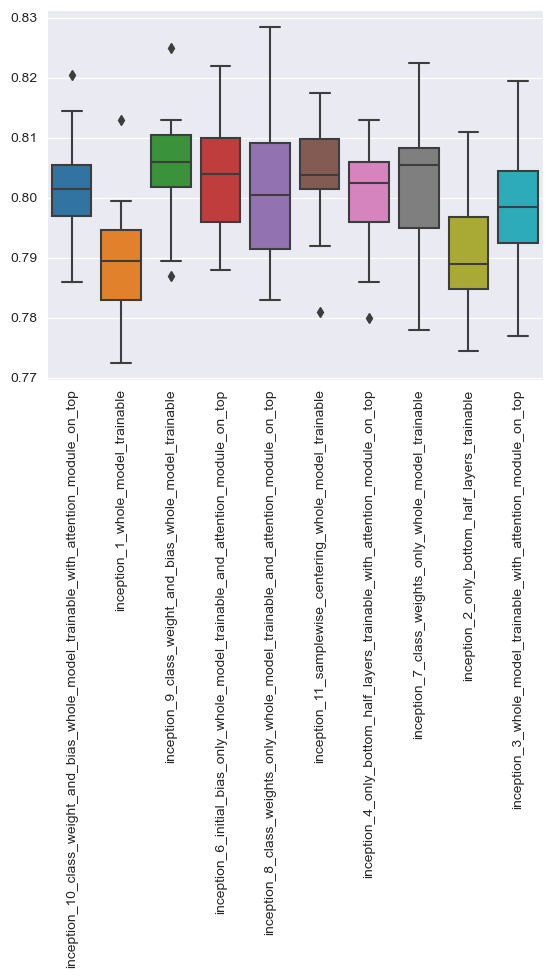

In [19]:
group_stats = {group: (np.mean(values), np.std(values)) for group, values in group_data.items()}

for group, (mean, std) in group_stats.items():
    print(f"{group}: Mean = {mean:.2f}, Std = {std:.2f}")

sns.boxplot(x=tukey_cols, y=tukey_vals)
plt.xticks(rotation=90)
plt.show()

In conclusion:

1. ANOVA and Kruskal-Wallis tests have shown that there are statistically significant differences between the models performances, which is confirmed by the boxplots interpretation. A null hypothesis of all the groups having the same mean could have been rejected.
2. Cohen-d values for 2 of the best performing models, that is:
    - 9_class_weight_and_bias_whole_model_trainable
    - 11_samplewise_centering_whole_model_trainable
   have shown that magnitudes of the differences of those models are statistically insignificant.
3. At the same time those are the 2 best performing models. It's not easily visible which one of them is the clear winner, but since the 9_class_weight_and_bias_whole_model_trainable doesn't require any image preprocessing, that one will be picked for the final verdict.

Now let's pick the best model instance to see the confusion matrix for best model.

In [18]:
name = ''
best_acc = 0

for key, value in accuracies.items():
    if ('9_class_weight_and_bias_whole_model_trainable' in key or 'inception_5_initial_bias_only_whole_model_trainable' in key) and value > best_acc:
        name = key
        best_acc = value

model_path = os.path.join(models_dir, name)
model = keras.models.load_model(model_path)
y_pred_labels = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred_labels, axis=-1)

63/63 [==============================] - 10s 57ms/step


As seen in the generated bar plot, the best model has ~82% accuracy, let's confirm that:

In [19]:
y_test = []

for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=-1))

y_test = np.array(y_test)
pred_accuracy = np.sum(y_pred_labels == y_test) / len(y_test)

print(f"Accuracy of predictions: {pred_accuracy * 100:.2f}%")

Accuracy of predictions: 82.50%


              precision    recall  f1-score   support

       akiec       0.66      0.51      0.57        65
         bcc       0.75      0.75      0.75       102
         bkl       0.54      0.79      0.64       219
          df       0.82      0.61      0.70        23
         mel       0.69      0.41      0.51       222
          nv       0.91      0.93      0.92      1341
        vasc       0.95      0.68      0.79        28

    accuracy                           0.82      2000
   macro avg       0.76      0.67      0.70      2000
weighted avg       0.83      0.82      0.82      2000



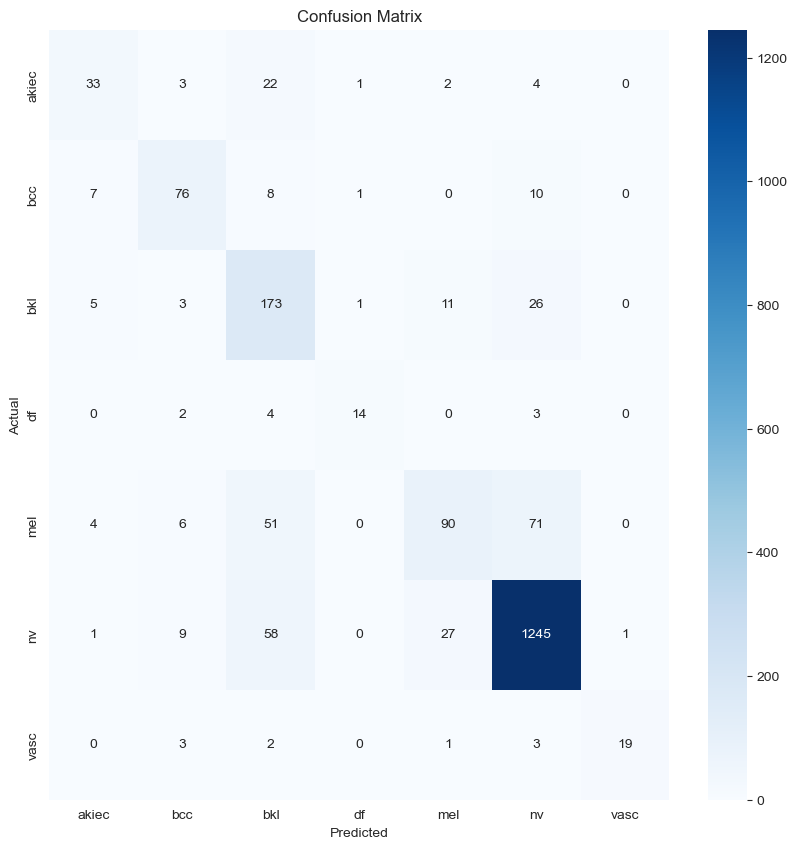

In [20]:
report = classification_report(y_test, y_pred_labels, target_names=test_ds.class_names, zero_division=0)
print(report)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

It's very visible that the model despite having over 82% accuracy, still gets somewhat confused by some of the classes. Now let's consider the other model that was present in the kruskal_walis_testable_groups

In [21]:
model_name = ''
best_acc = 0

for key, value in accuracies.items():
    if kruskal_walis_testable_groups[0] in key and value > best_acc:
        model_name = key
        best_acc = value

model_path = os.path.join(models_dir, model_name)
chosen_model = keras.models.load_model(model_path)
kw_model_prediction = chosen_model.predict(test_ds)
y_pred_labels = np.argmax(kw_model_prediction, axis=-1)

63/63 [==============================] - 7s 59ms/step


In [23]:
y_test = []

for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=-1))

y_test = np.array(y_test)
pred_accuracy = np.sum(y_pred_labels == y_test) / len(y_test)

print(f"Accuracy of predictions: {pred_accuracy * 100:.2f}%")

Accuracy of predictions: 81.30%


              precision    recall  f1-score   support

       akiec       0.71      0.26      0.38        65
         bcc       0.77      0.58      0.66       102
         bkl       0.55      0.69      0.61       219
          df       0.52      0.70      0.59        23
         mel       0.65      0.44      0.52       222
          nv       0.89      0.94      0.92      1341
        vasc       1.00      0.71      0.83        28

    accuracy                           0.81      2000
   macro avg       0.73      0.62      0.65      2000
weighted avg       0.81      0.81      0.80      2000



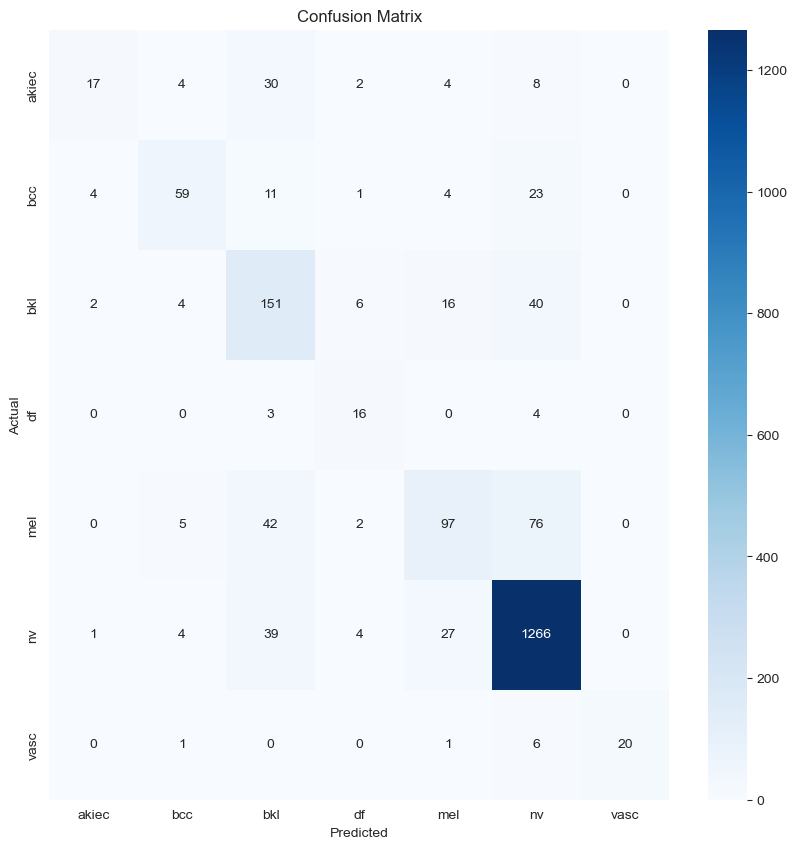

In [24]:
report = classification_report(y_test, y_pred_labels, target_names=test_ds.class_names, zero_division=0)
print(report)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()